In [1]:
from IPython.display import display,HTML
display(HTML('<style>.container {width: 98% !important}</style>'))

In [1]:
%matplotlib notebook

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# filename='tmp.txt'
# text=[]
# with open(filename) as file:
#     for line in file:
#         text.append([line.strip()])
# #         print(line.rstrip())
# print(text)

In [4]:
# x=torch.randn(3,4).view(1,1,-1)
# print(x.shape)
# print(x[0].shape)
# # h=torch.zeros(1,60)
# # h=torch.cat((x[0],h),1)
# # print(h.shape)
# # x=h,dim=1

In [5]:
days=['sunday ','monday ','tuesday ','wednesday ','thursday ','friday ','saturday ','sun ','mon ','tue ','wed ','thu ','fri ','sat ',"'"]
month={'january':'jan','february':'feb','march':'mar',
       'april':'apr','june':'jun','july':'jul','august':'aug','september':'sept','sep':'sept','october':'oct','november':'nov',
       'december':'dec'}


In [6]:
cols=['Source','Target']
df=pd.read_csv('Assignment4aDataset.txt',names=cols, sep=', ',header=None)
print(df)

C:\Users\mayan\AppData\Local\Temp\ipykernel_20180\1612482889.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('Assignment4aDataset.txt',names=cols, sep=', ',header=None)


                       Source        Target
0               'may 20 2034'  '2034-05-20'
1                '9 may 1630'  '1630-05-09'
2                '15/03/2014'  '2014-03-15'
3               'mar 16 1675'  '1675-03-16'
4               'jun 16 1640'  '1640-06-16'
...                       ...           ...
39995      'december 26 1900'  '1900-12-26'
39996           '15 may 1828'  '1828-05-15'
39997  'friday april 18 1851'  '1851-04-18'
39998          'june 11 2070'  '2070-06-11'
39999       'january 27 1712'  '1712-01-27'

[40000 rows x 2 columns]


In [7]:
regx = r'({})'.format('|'.join(days))
df['Source'] = df['Source'].str.replace(regx, "").fillna(df['Source'])

C:\Users\mayan\AppData\Local\Temp\ipykernel_20180\2800865422.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Source'] = df['Source'].str.replace(regx, "").fillna(df['Source'])


In [8]:
# replace space with slash
space=[' ']
regx2 = r'({})'.format('|'.join(space))
df['Source'] = df['Source'].str.replace(regx2, "/").fillna(df['Source'])

C:\Users\mayan\AppData\Local\Temp\ipykernel_20180\2027209658.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Source'] = df['Source'].str.replace(regx2, "/").fillna(df['Source'])


In [9]:
# print(regx)

In [10]:
d2 = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in month.items()}
df['Source'] = df['Source'].replace(d2, regex=True)

In [11]:
pre=["'"]
regx = r'({})'.format('|'.join(pre))
df['Target'] = df['Target'].str.replace(regx, "").fillna(df['Target'])

C:\Users\mayan\AppData\Local\Temp\ipykernel_20180\3973151500.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Target'] = df['Target'].str.replace(regx, "").fillna(df['Target'])


In [12]:
print(df)
df_train, df_valid = train_test_split(df, test_size=0.1)
print(len(df_train))
print(len(df_valid))

            Source      Target
0      may/20/2034  2034-05-20
1       9/may/1630  1630-05-09
2       15/03/2014  2014-03-15
3      mar/16/1675  1675-03-16
4      jun/16/1640  1640-06-16
...            ...         ...
39995  dec/26/1900  1900-12-26
39996  15/may/1828  1828-05-15
39997  apr/18/1851  1851-04-18
39998  jun/11/2070  2070-06-11
39999  jan/27/1712  1712-01-27

[40000 rows x 2 columns]
36000
4000


In [13]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 11


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS":0,"EOS":1}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence,lang):
        if lang=='Source':
            words=[]
            nums=[]
            words=sentence.split('/')
            for w in words:
                if w.isdigit():
                    nums.extend(c for c in w)
                else:
                    nums.append(w)

                nums.append("/")
            nums=nums[:-1]
            for num in nums:
                self.addWord(num)
                
        else:
            words=[]
            nums=[]
            words=sentence.split('-')
            for w in words:
                if w.isdigit():
                    nums.extend(c for c in w)
                else:
                    nums.append(w)

                nums.append("-")
            nums=nums[:-1]
            for num in nums:
                self.addWord(num)
            
            
            
            

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [14]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang

In [15]:
def prepareData(lang1, lang2, df):
    input_lang, output_lang = readLangs(lang1, lang2)


    print("Counting words...")
    for i, row in enumerate(df.values):
        input_lang.addSentence(row[0],lang1)
        output_lang.addSentence(row[1],lang2)
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang


input_lang, output_lang = prepareData('Source', 'Target',df_train)
print(input_lang.word2index)
print(output_lang.word2index)

# print(random.choice(pairs))

Reading lines...
Counting words...
Counted words:
Source 25
Target 13
{'SOS': 0, 'EOS': 1, 'mar': 2, '/': 3, '4': 4, '1': 5, '8': 6, '7': 7, 'oct': 8, '2': 9, '5': 10, '0': 11, '6': 12, 'sept': 13, '3': 14, 'jul': 15, 'aug': 16, 'dec': 17, '9': 18, 'jan': 19, 'jun': 20, 'nov': 21, 'may': 22, 'apr': 23, 'feb': 24}
{'SOS': 0, 'EOS': 1, '1': 2, '8': 3, '4': 4, '7': 5, '-': 6, '0': 7, '3': 8, '2': 9, '5': 10, '6': 11, '9': 12}


In [16]:
print(output_lang.index2word)

{0: 'SOS', 1: 'EOS', 2: '1', 3: '8', 4: '4', 5: '7', 6: '-', 7: '0', 8: '3', 9: '2', 10: '5', 11: '6', 12: '9'}


In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
def indexesFromSentence(lang, sentence , name):
    if name=='Source':
        words=[]
        nums=[]
        words=sentence.split('/')
        for w in words:
            if w.isdigit():
                nums.extend(c for c in w)
            else:
                nums.append(w)

            nums.append("/")
        nums=nums[:-1]
        for num in nums:
            lang.addWord(num)

    else:
        words=[]
        nums=[]
        words=sentence.split('-')
        for w in words:
            if w.isdigit():
                nums.extend(c for c in w)
            else:
                nums.append(w)

            nums.append("-")
        nums=nums[:-1]
        for num in nums:
            lang.addWord(num)
            
    return [lang.word2index[word] for word in nums]


def tensorFromSentence(lang,sentence,name):
    indexes = indexesFromSentence(lang, sentence,name)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0],"Source")
    target_tensor = tensorFromSentence(output_lang, pair[1],"Target")
    return (input_tensor, target_tensor)



In [20]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
# def validate_iter(encoder,decoder,n_iters=len(df_valid)):
# #     start = time.time()
# #     plot_losses = []
#     print_loss_total = 0  # Reset every print_every
#     plot_loss_total = 0  # Reset every plot_every

# #     encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
# #     decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
# #     training_pairs = getPair()
    
# #     training_pairs = [tensorsFromPair(getPair())
# #                       for i in range(n_iters)]
#     criterion = nn.NLLLoss()

#     for iter in range(1, n_iters + 1):
#         valid_pair = tensorsFromPair(getPair())
#         input_tensor = valid_pair[0]
#         target_tensor = valid_pair[1]

#         loss = validate(input_tensor, target_tensor, encoder,
#                      decoder, encoder_optimizer, decoder_optimizer, criterion)
#         print_loss_total += loss
#         plot_loss_total += loss

# #         if iter % print_every == 0:
#     print_loss_avg = print_loss_total / n_iters
#     print_loss_total = 0
#     print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
#                                  iter, iter / n_iters * 100, print_loss_avg))
            

# #         if iter % plot_every == 0:
#     plot_loss_avg = plot_loss_total / n_iters
#     plot_losses.append(plot_loss_avg)
#     plot_loss_total = 0

#     showPlot(plot_losses)
    

def validate(encoder, decoder, criterion,sentence,target, max_length=MAX_LENGTH):
    with torch.no_grad():
#         print(f'sentence : {sentence} target : {target}')
        
        input_tensor,target_tensor = tensorsFromPair([sentence,target])
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        pred=[]
        loss=0
        
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            
            loss += criterion(decoder_output, target_tensor[di])
            
            
            pred.append(topi[0][0].to('cpu')== target_tensor[di][0].to('cpu'))
#             print(f'di:{di} topi={topi[0][0]} target_tensor[di] :{target_tensor[di][0]} ')
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                while di<MAX_LENGTH-1:
                    pred.append(False)
#                     print(f'di adding {di}')

                    di+=1
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
#         print(len(pred))

        return decoder_attentions[:di + 1],np.array(pred),loss

In [23]:
idx=0

In [24]:

def getPair():
    global idx
    global df_train
#     print(idx)
    if idx==0:
        df_train = shuffle(df_train)
        
#     x=df_train.sample()
    retval=[df_train.iloc[idx]["Source"],df_train.iloc[idx]["Target"]]
    idx=(idx+1) % len(df_train)
    return retval



def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_vlosses = []
    plot_vloss_total = 0
    min_vloss=np.inf

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
#     training_pairs = getPair()
    
#     training_pairs = [tensorsFromPair(getPair())
#                       for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = tensorsFromPair(getPair())
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            
#             validate_iter(encoder, decoder)
            tot_vloss=0
            exact_acc=0
            avg_acc=0
            

            
            pred_tot=np.zeros(MAX_LENGTH)
            
            
            for i in range(len(df_valid)):
                dec_att,pred,vloss=validate(encoder, decoder,criterion,df_valid.iloc[i]['Source'],
                         df_valid.iloc[i]['Target'], max_length=MAX_LENGTH)
                
#                 print(f'pred_tot: {pred_tot}')
#                 print(f'pred: {pred}')
                
                pred_tot+=pred
                
                tot_vloss+=vloss
                plot_vloss_total += loss
                sum_pred=np.sum(pred)    #shoud be pred?
                if sum_pred == MAX_LENGTH:
                    exact_acc+=1
                    
                avg_acc+=sum_pred/MAX_LENGTH     
                    
                
                
            print(f'Valid_Loss: {tot_vloss/len(df_valid)}, Pred per bit: {pred_tot/len(df_valid)}')
            print(f'Exact Acc: {exact_acc/len(df_valid)}, Avg Acc: {avg_acc/len(df_valid)}')
                
            if min_vloss > tot_vloss:
                torch.save(encoder.state_dict(), 'encoder.pth')
                torch.save(decoder.state_dict(), 'decoder.pth')
                print("Model Saved")
                

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            plot_vloss_avg = plot_vloss_total / plot_every
            plot_vlosses.append(plot_vloss_avg)
            plot_vloss_total = 0
            

    showPlot(plot_losses)
    showPlot(plot_vlosses)

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
#     plt.plot(vpoints)

In [28]:
hidden_size = 50
epoch=10
n_iters=epoch*len(df_train)
print(n_iters)
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.4).to(device)

trainIters(encoder1, attn_decoder1, n_iters=n_iters, print_every=9000)

360000
6m 41s (- 260m 39s) (9000 2%) 0.6237
Valid_Loss: 4.720592498779297, Pred per bit: [0.98175 0.91725 0.7425  0.82175 0.99825 0.8155  0.636   0.9975  0.85125
 0.85625 0.99575]
Exact Acc: 0.00025, Avg Acc: 1750.2112272727284
Model Saved
14m 56s (- 283m 51s) (18000 5%) 0.1969
Valid_Loss: 1.9627074003219604, Pred per bit: [0.98075 0.94375 0.88725 0.8995  1.      0.96225 0.8545  1.      0.9625
 0.9655  1.     ]
Exact Acc: 0.00025, Avg Acc: 1902.4101363636362
Model Saved
22m 56s (- 282m 56s) (27000 7%) 0.1186
Valid_Loss: 1.5603817701339722, Pred per bit: [0.993   0.9595  0.9425  0.92875 0.9985  0.9745  0.915   0.998   0.942
 0.96675 0.998  ]
Exact Acc: 0.00025, Avg Acc: 1932.0699999999922
Model Saved
31m 12s (- 280m 51s) (36000 10%) 0.0782
Valid_Loss: 0.9189862608909607, Pred per bit: [0.9945  0.969   0.9665  0.95175 0.9995  0.98925 0.955   0.9995  0.9745
 0.9805  0.9995 ]
Exact Acc: 0.00025, Avg Acc: 1961.8372045454303
Model Saved
39m 19s (- 275m 15s) (45000 12%) 0.0711
Valid_Loss: 0.7

KeyboardInterrupt: 

In [59]:

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence,"Source")
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1],input_tensor

In [60]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

tensor([[ 8],
        [ 3],
        [ 2],
        [ 3],
        [ 9],
        [10],
        [ 6],
        [ 5],
        [ 1]], device='cuda:0')
['9', '/', 'may', '/', '1', '6', '3', '0', 'EOS']
torch.Size([11, 11])


<IPython.core.display.Javascript object>


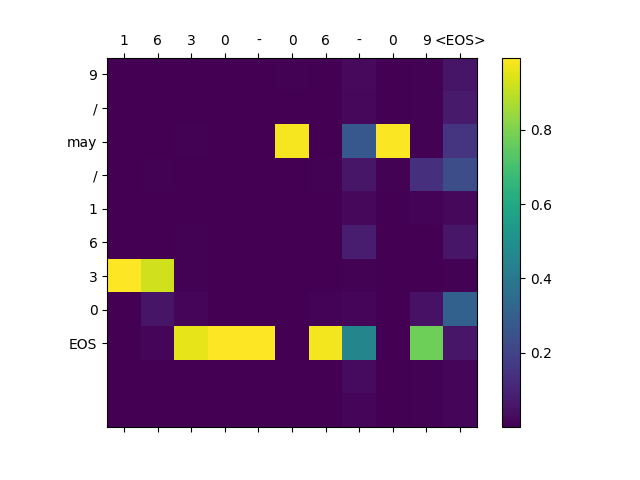

In [31]:
# output_words, attentions,input_tensor= evaluate(
#     encoder1, attn_decoder1,df.iloc[1]["Source"])

# print(input_tensor)
# ip=[]
# for i in input_tensor.cpu().detach().numpy():
#     ip.append(input_lang.index2word[i[0]])
# print(ip)


# # sentence=df.iloc[0]["Source"]
# # words=[]
# # nums=[]
# # words=sentence.split('/')
# # for w in words:
# #     if w.isdigit():
# #         nums.extend(c for c in w)
# #     else:
# #         nums.append(w)

# #     nums.append("/")
# # nums=nums[:-1]
# # nums.append('<EOS>')

# # print(nums)

# # print(attentions.numpy().size)
# # print(output_words)
# # plt.matshow(attentions.numpy())

# print(attentions.shape)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(attentions.T.numpy())
# fig.colorbar(cax)

# xaxis = np.arange(len(output_words))
# yaxis = np.arange(len(ip))

# ax.set_xticks(xaxis)
# ax.set_yticks(yaxis)
# ax.set_xticklabels(output_words)
# ax.set_yticklabels(ip)
# plt.show()

In [61]:
def showAttention(input_sentence, output_words, attentions,input_tensor):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes

    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    
    ip=[]
    for i in input_tensor.cpu().detach().numpy():
        ip.append(input_lang.index2word[i[0]])
    print(ip)
    ax.set_xticklabels(['']+ip)
    
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions,input_tensor = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions,input_tensor)

input = 12/17/51
output = 1 7 5 1 - 1 2 - 1 7 <EOS>


<IPython.core.display.Javascript object>


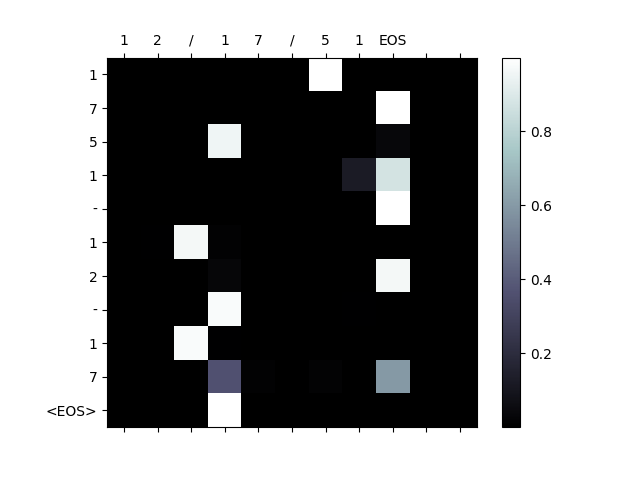

['1', '2', '/', '1', '7', '/', '5', '1', 'EOS']


C:\Users\mayan\AppData\Local\Temp\ipykernel_11008\2221226199.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
C:\Users\mayan\AppData\Local\Temp\ipykernel_11008\2221226199.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ip)


In [62]:
evaluateAndShowAttention(df_train.iloc[1]["Source"])

input = 9/may/1630
output = 1 6 3 0 - 0 6 - 0 9 <EOS>


<IPython.core.display.Javascript object>


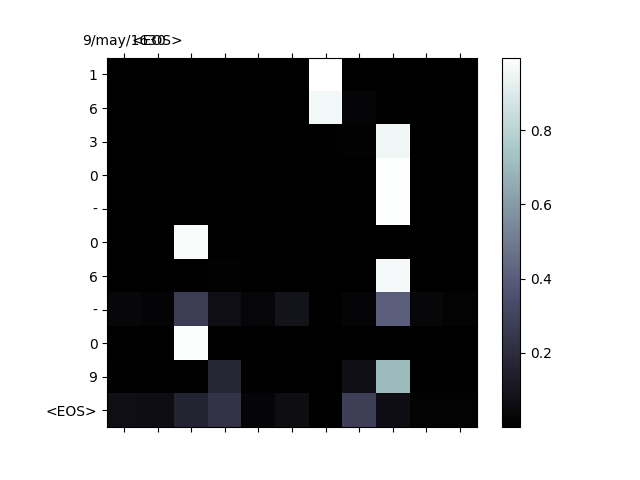

C:\Users\mayan\AppData\Local\Temp\ipykernel_17652\576983292.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\mayan\AppData\Local\Temp\ipykernel_17652\576983292.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [36]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'])
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions,input_tensor = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention(df_train.iloc[1]["Source"])

## Rough

In [99]:
tmp=df['Source'][0]
tmp='20/02/1998'
print(tmp)

words=tmp.split('/')

# d = "/"

# words = [e+d for e in tmp.split(d) if e]
# print(words)


nums=[]
print(words)
for w in words:
    if w.isdigit():
        nums.extend(c for c in w)
    else:
        nums.append(w)
        
    nums.append("/")
nums=nums[:-1]
print(nums)
        

20/02/1998
['20', '02', '1998']
['2', '0', '/', '0', '2', '/', '1', '9', '9', '8']


In [85]:
for i, row in enumerate(df.values):
    print(row[0])

may/20/2034
9/may/1630
15/03/2014
mar/16/1675
jun/16/1640
1791/2/09
1776/11/sept
1833/9/jun
26/oct/1788
1685/30/oct
12/17/51
oct/21/2051
jul/11/1562
29/apr/1979
11/23/13
6/dec/1802
sept/23/2066
nov/6/1567
apr/1/1836
20/jun/1905
dec/10/1700
aug/30/1995
nov/13/1753
oct/28/1801
feb/11/1896
26/feb/2045
22/sept/2068
may/18/2037
2/jan/1980
28/may/1931
10/aug/1548
oct/26/1760
may/19/2058
jun/23/1865
sept/23/2035
jul/27/1902
jan/27/1911
feb/25/1935
1670/15/may
mar/13/1877
1782/30/nov
may/2/1840


In [102]:
tmp=df['Target'][0]
# tmp='20/02/1998'
print(tmp)

words=tmp.split('-')

# d = "/"

# words = [e+d for e in tmp.split(d) if e]
# print(words)


nums=[]
print(words)
for w in words:
    if w.isdigit():
        nums.extend(c for c in w)
    else:
        nums.append(w)
        
    nums.append("-")
nums=nums[:-1]
print(nums)
        

2034-05-20
['2034', '05', '20']
['2', '0', '3', '4', '-', '0', '5', '-', '2', '0']


In [145]:
x=df.sample()
print(x)
print([x.iloc[0]["Source"],x.iloc[0]["Target"]])

         Source      Target
33  jun/23/1865  1865-06-23
['jun/23/1865', '1865-06-23']


In [15]:
for i in range(len(df_valid)):
    print(df_valid.iloc[0]['Source'])
    print(df_valid.iloc[0]['Target'])

jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991

1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11


jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991
1991-07-11
jul/11/1991